# Sphere Sampling Script

This script shows how to use a sphere model to sample semi-landmark points on the surface of a template image. The sphere, placed at the arithmatic center of the image, is sampled in the latitude and longitude directions. The sphere points are projected to the template surface along the surface normals using a utility function defined in the example. After projection to the surface, the points are filtered to remove duplicate points witin a radius defined by the variable polydataCleanRadius.

## Set up input parameters

Clear the scene and set the input filename, sphere sampling parameters in the latitude and longitude directions, and filtering radius for the final clean-up step after the semi-landmarks have been generated. Low sampling rates are used here to increase the processing speed of the example.

In [1]:
# clear scene
slicer.mrmlScene.Clear()

import os
currentPath = os.getcwd()

# Set up parameters
templateMeshFile = os.path.join(currentPath, "notebookData\Gor_template_000.vtk")
thetaResolution = 40
phiResolution = 20 
polydataCleanRadius = 5

## Utility to project points from a source surface to a target surface 

This function takes a source polydata surface with landmark points and projects them onto a target surface along the surface normals of the source polydata. The points are first projected to the last intersection with the target surface in the direction of the surface normal. The maximum length of the search vector is defined by the variable rayLength. If no exterior surface is found, the point is projected in the opposite direction to the first intersection with the target surface.

In [2]:
def projectPoints(sourcePolydata, targetPolydata, originalPoints, projectedPoints, rayLength):
    #set up locater for intersection with normal vector rays
    obbTree = vtk.vtkOBBTree()
    obbTree.SetDataSet(targetPolydata)
    obbTree.BuildLocator()
    
    #set up point locator for finding surface normals and closest point
    pointLocator = vtk.vtkPointLocator()
    pointLocator.SetDataSet(sourcePolydata)
    pointLocator.BuildLocator()
    
    targetPointLocator = vtk.vtkPointLocator()
    targetPointLocator.SetDataSet(targetPolydata)
    targetPointLocator.BuildLocator()
    
    #get surface normal from each landmark point
    rayDirection=[0,0,0]
    normalArray = sourcePolydata.GetPointData().GetArray("Normals")
    if(not normalArray):
      normalFilter=vtk.vtkPolyDataNormals()
      normalFilter.ComputePointNormalsOn()
      normalFilter.SetInputData(sourcePolydata)
      normalFilter.Update()
      normalArray = normalFilter.GetOutput().GetPointData().GetArray("Normals")
      if(not normalArray):
        print("Error: no normal array")
    
    for index in range(originalPoints.GetNumberOfMarkups()):
      originalPoint=[0,0,0]
      originalPoints.GetMarkupPoint(0,index,originalPoint)
      # get ray direction from closest normal
      closestPointId = pointLocator.FindClosestPoint(originalPoint)
      rayDirection = normalArray.GetTuple(closestPointId)
      rayEndPoint=[0,0,0]
      for dim in range(len(rayEndPoint)):
        rayEndPoint[dim] = originalPoint[dim] + rayDirection[dim]* rayLength
      intersectionIds=vtk.vtkIdList()
      intersectionPoints=vtk.vtkPoints()
      obbTree.IntersectWithLine(originalPoint,rayEndPoint,intersectionPoints,intersectionIds)
      #if there are intersections, update the point to most external one.
      if intersectionPoints.GetNumberOfPoints() > 0:
        exteriorPoint = intersectionPoints.GetPoint(intersectionPoints.GetNumberOfPoints()-1)
        projectedPoints.AddFiducialFromArray(exteriorPoint)
      #if there are no intersections, reverse the normal vector
      else: 
        for dim in range(len(rayEndPoint)):
          rayEndPoint[dim] = originalPoint[dim] + rayDirection[dim]* -rayLength
        obbTree.IntersectWithLine(originalPoint,rayEndPoint,intersectionPoints,intersectionIds)
        if intersectionPoints.GetNumberOfPoints()>0:
          exteriorPoint = intersectionPoints.GetPoint(0)
          projectedPoints.AddFiducialFromArray(exteriorPoint)
    return True

## Load the template mesh and set sphere parameters

In [3]:
# load template mesh and landmarks
templateMeshNode = slicer.util.loadModel(templateMeshFile)
[x1,x2,y1,y2,z1,z2] = templateMeshNode.GetPolyData().GetBounds()
sphereCenter = [((x2-x1)/2)+x1, ((y2-y1)/2)+y1 ,((z2-z1)/2)+z1]
xDimensionLength = abs(x2-x1)
sphereRadius = xDimensionLength/2

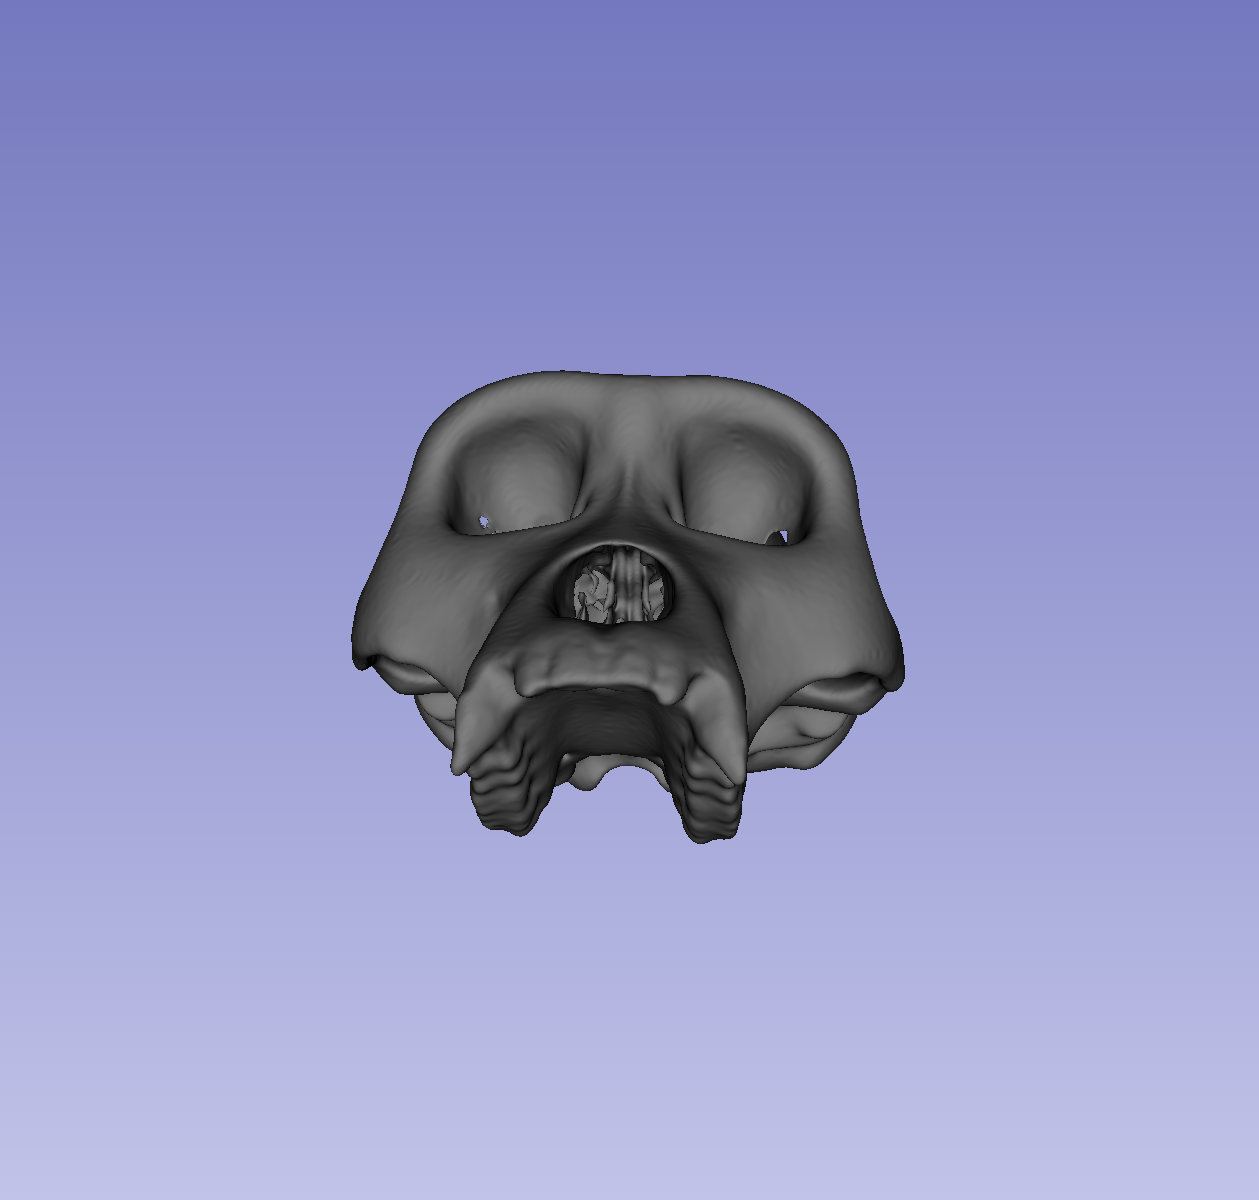

In [4]:
# Display and center view
layoutManager = slicer.app.layoutManager()
layoutManager.setLayout(slicer.vtkMRMLLayoutNode.SlicerLayoutOneUp3DView)
layoutManager.threeDWidget(0).threeDView().resetCamera()
display()

## Generate and visulize the sampled sphere and confirm number of points

In this example, the sphere center and radius are set using the center and size of the template mesh. After the sphere is generated, confirm that the number of sampled sphere points is sufficient. The final number of semi-landmarks will be reduced in the final filtering step.

In [5]:
# Generate a sphere
sphere=vtk.vtkSphereSource()
sphere.SetThetaResolution(thetaResolution)
sphere.SetPhiResolution(phiResolution)
sphere.SetRadius(sphereRadius)
sphere.SetCenter(sphereCenter)
sphere.Update()
spherePolyData=sphere.GetOutput()
print('Sampling ' + str(spherePolyData.GetNumberOfPoints()) + ' points on the sphere.')

Sampling 722 points on the sphere.


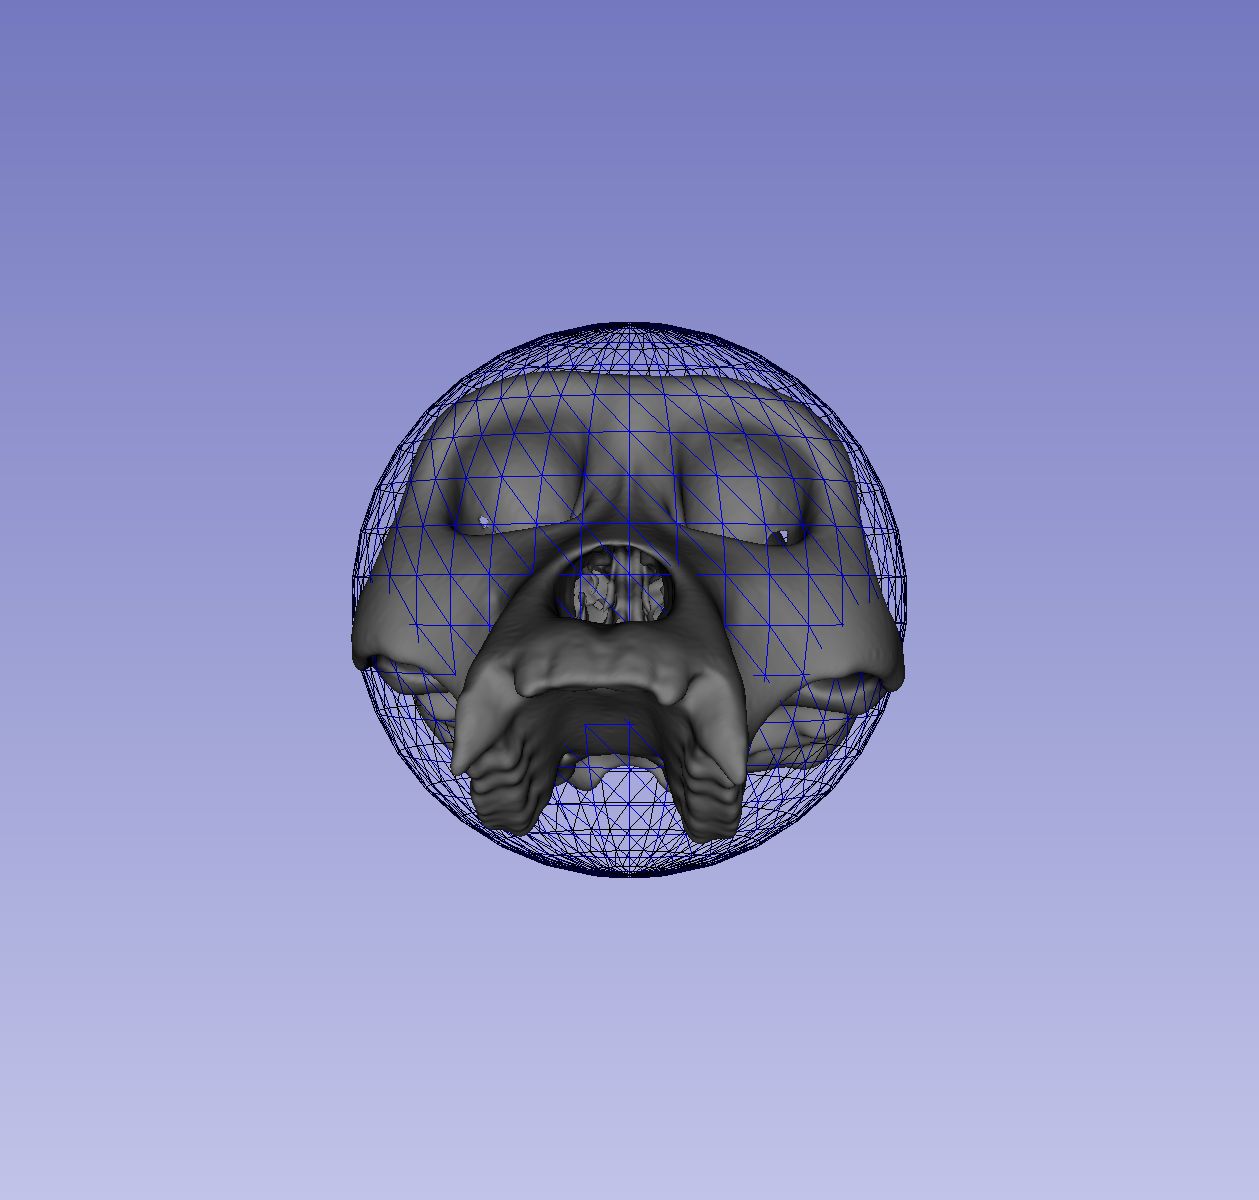

In [6]:
# Add sphere to the scene to visualize
modelNode= slicer.mrmlScene.AddNewNodeByClass('vtkMRMLModelNode',"sphereModel")
modelNode.SetAndObservePolyData(spherePolyData)
modelNode.CreateDefaultDisplayNodes()
# set to "wire frame" surface representation
modelNode.GetDisplayNode().SetRepresentation(1)
modelNode.GetDisplayNode().SetColor(0,0,1)
display()

## Convert sphere points to fiducials

In [7]:
# Create a landmark node containing the points on the sphere
semiLMNode= slicer.mrmlScene.AddNewNodeByClass('vtkMRMLMarkupsFiducialNode',"spherePoints")
for i in range(spherePolyData.GetNumberOfPoints()):
  point = spherePolyData.GetPoint(i)
  semiLMNode.AddFiducialFromArray(point)


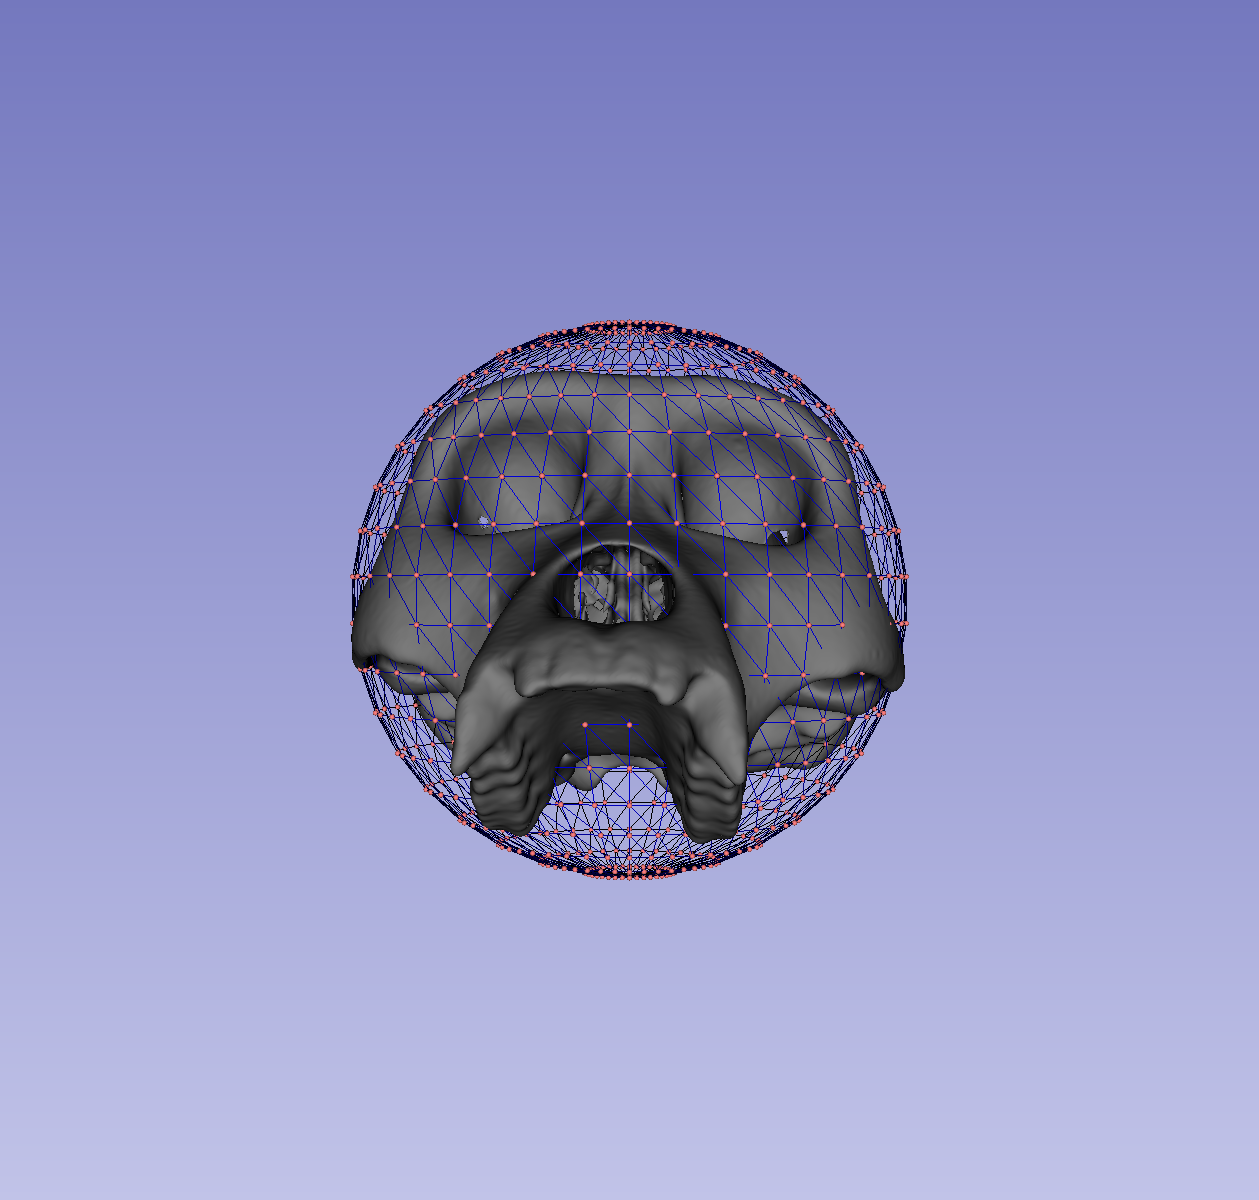

In [8]:
semiLMNode.GetDisplayNode().SetPointLabelsVisibility(False)
display()

## Project sphere points onto the gorilla template mesh

In [11]:
# Project sphere points to the mesh surface
projectedLM= slicer.mrmlScene.AddNewNodeByClass('vtkMRMLMarkupsFiducialNode',"projectedLM")
success = projectPoints(modelNode.GetPolyData(), templateMeshNode.GetPolyData(), semiLMNode, projectedLM, 1000)

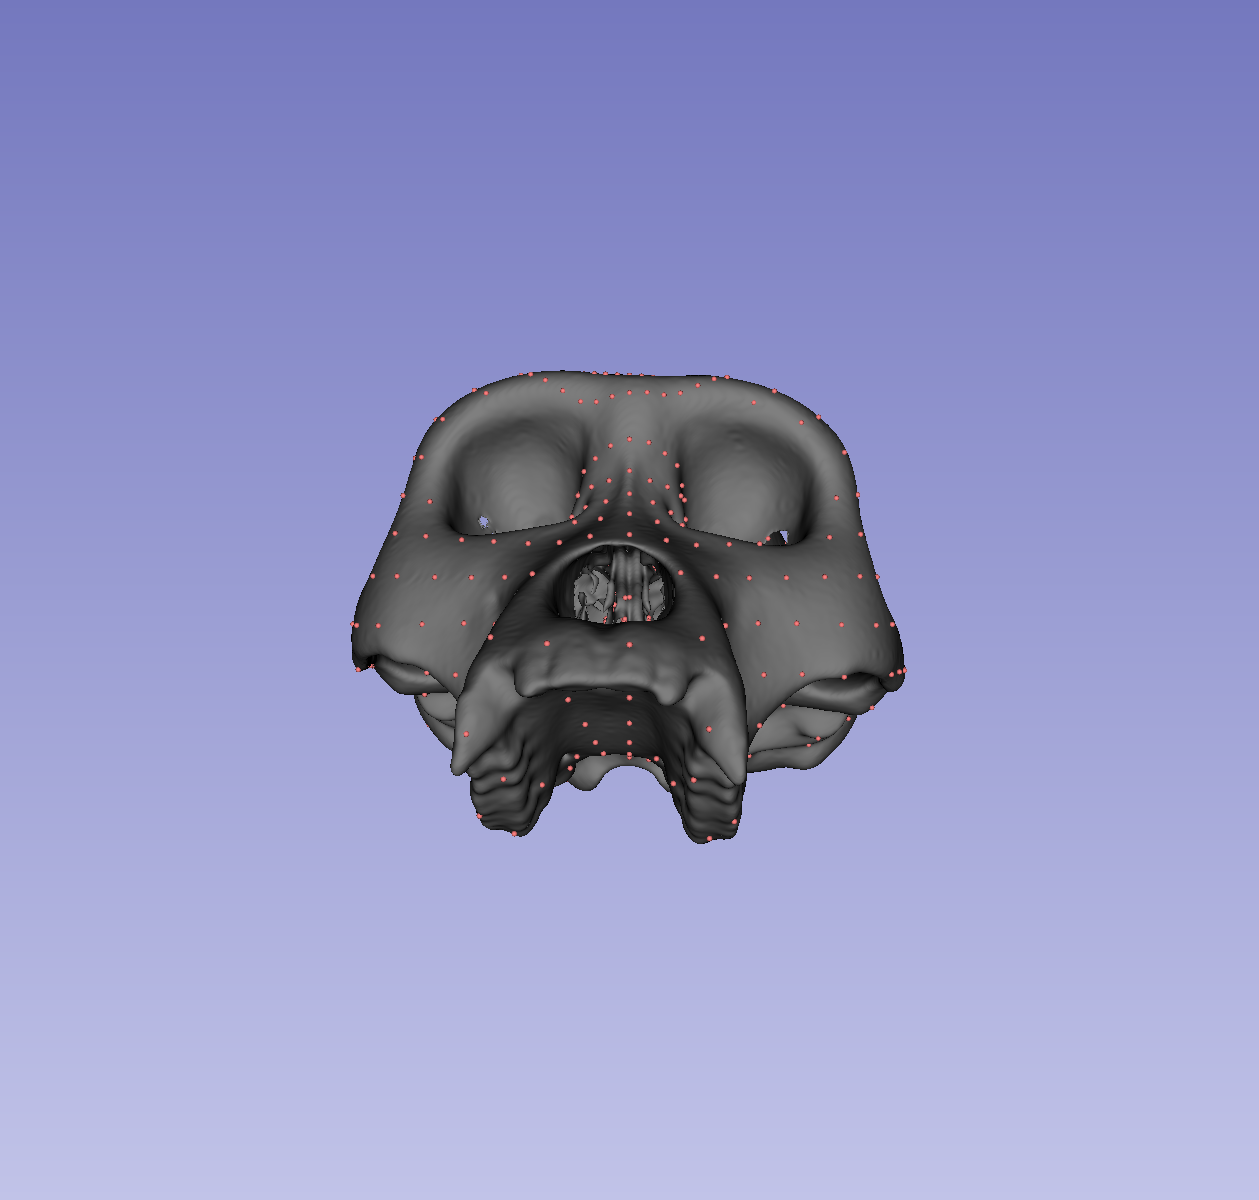

In [12]:
semiLMNode.SetDisplayVisibility(False)
modelNode.SetDisplayVisibility(False)
projectedLM.GetDisplayNode().SetPointLabelsVisibility(False)
display()

## Generate a spherical mesh connecting the semi-landmark points 

To filter the mesh points, a mesh determining their connectivity is needed. This mesh is generated by warping the sphere using a thin-plate spline transform between the sphere points and the points projected from the sphere onto the mesh surface.

In [13]:
# Convert projected surface points to a VTK array for transform
p=[0,0,0]
targetPoints = vtk.vtkPoints()
for i in range(projectedLM.GetNumberOfFiducials()):
  projectedLM.GetMarkupPoint(0,i,p)
  targetPoints.InsertNextPoint(p)

In [14]:
# Set up a transform between the sphere and the points projected to the surface
transform = vtk.vtkThinPlateSplineTransform()
transform.SetSourceLandmarks( spherePolyData.GetPoints() )
transform.SetTargetLandmarks( targetPoints )
transform.SetBasisToR()

# Apply the transform to the sphere to create a model with spherical topology
transformNode=slicer.mrmlScene.AddNewNodeByClass("vtkMRMLTransformNode","TPS")
transformNode.SetAndObserveTransformToParent(transform)
modelNode.SetAndObserveTransformNodeID(transformNode.GetID())  
slicer.vtkSlicerTransformLogic().hardenTransform(modelNode)

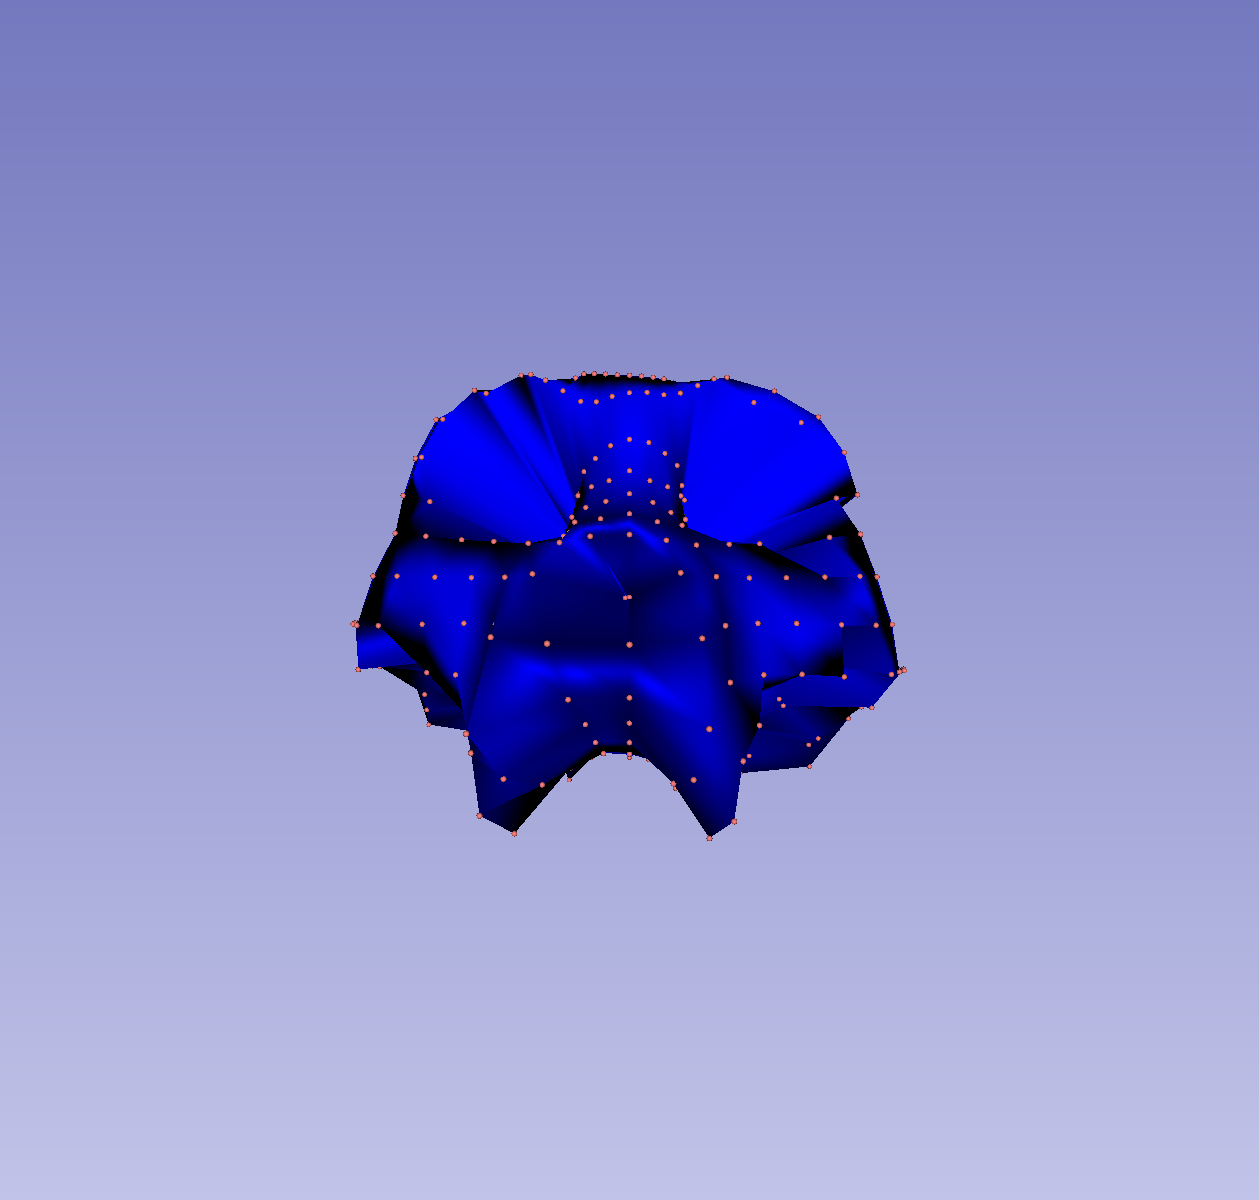

In [15]:
templateMeshNode.SetDisplayVisibility(False)
modelNode.SetDisplayVisibility(True)
modelNode.GetDisplayNode().SetRepresentation(2)
display()

## Filter polydata to remove points within a radius and check final point number

After the points are filtered using the vtkCleanPolydata filter, the number of points should be checked and confirmed to be sufficent. If more points are needed, the sphere sampling should be increased or the filtering radius decreased. To improve sampling regularity, the number of points can be increased and the filtering radius decreased.

In [16]:
# Clean up semi-landmarks within radius
filter=vtk.vtkCleanPolyData()
filter.SetToleranceIsAbsolute(True)
filter.SetAbsoluteTolerance(polydataCleanRadius)
filter.SetInputData(modelNode.GetPolyData())
filter.Update()
cleanPolydata=filter.GetOutput()
#confirm number of cleaned points is in the expected range
print('After filtering there are ' + str(cleanPolydata.GetNumberOfPoints()) + ' semi-landmark points')

After filtering there are 553 semi-landmark points


## Convert the filtered polydata points to a fiducial node

In [17]:
# Create a landmark node from the cleaned polydata
sphereSampleLMNode= slicer.mrmlScene.AddNewNodeByClass('vtkMRMLMarkupsFiducialNode',"sphereSampledLandmarks")
for i in range(cleanPolydata.GetNumberOfPoints()):
  point = cleanPolydata.GetPoint(i)
  sphereSampleLMNode.AddFiducialFromArray(point)

## Display final point set on template surface

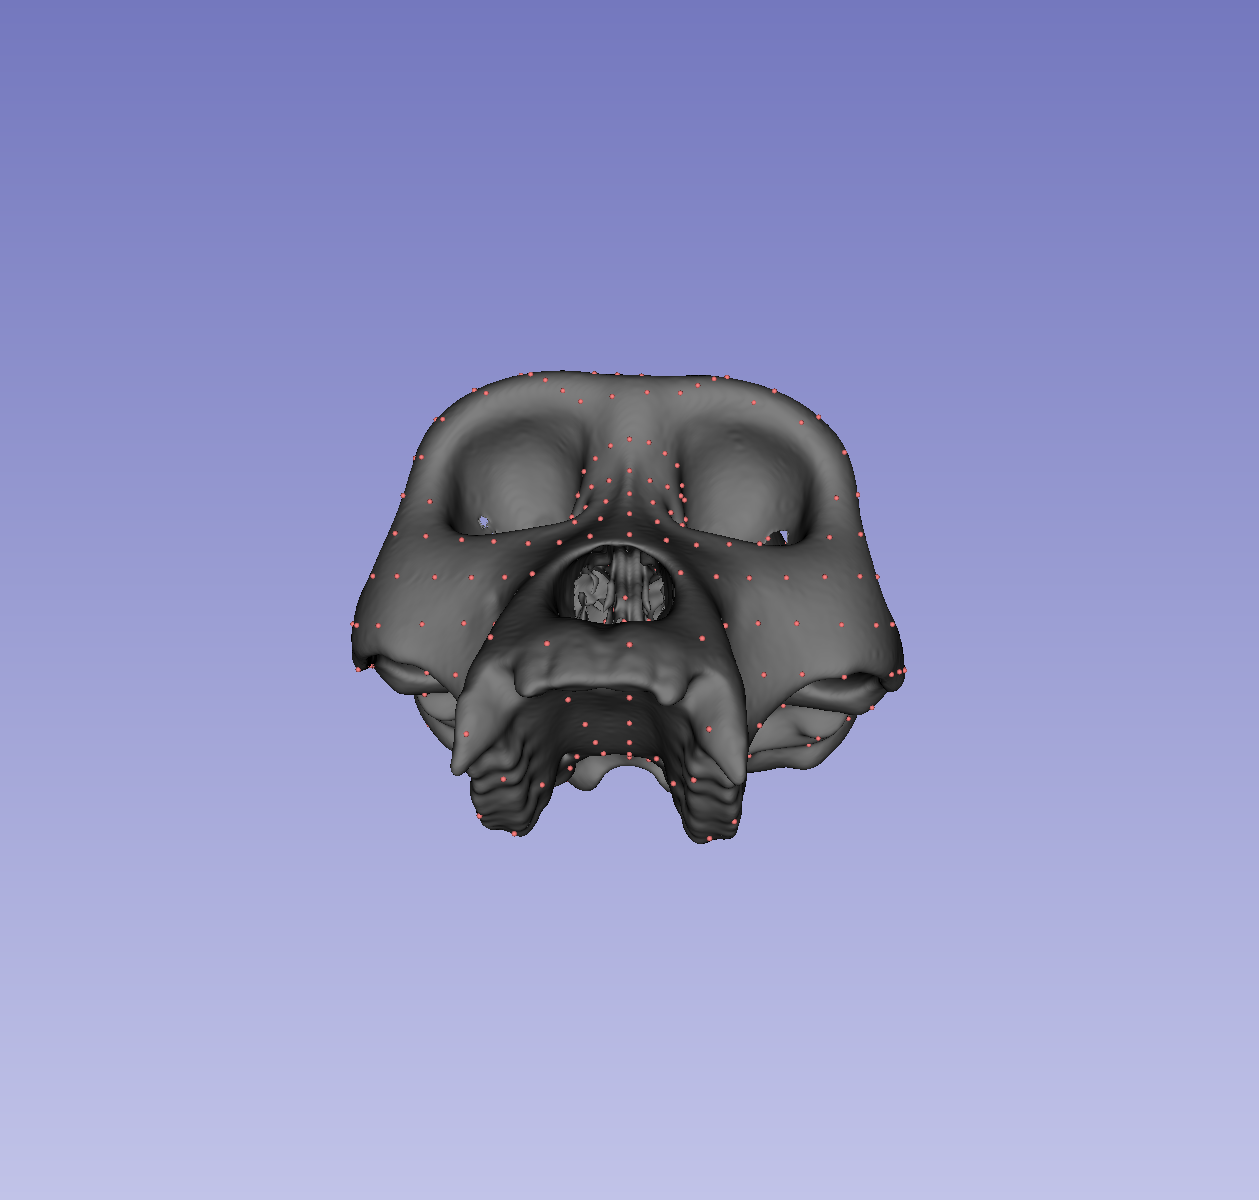

In [18]:
templateMeshNode.SetDisplayVisibility(True)
modelNode.SetDisplayVisibility(False)
projectedLM.SetDisplayVisibility(False)
sphereSampleLMNode.GetDisplayNode().SetPointLabelsVisibility(False)
display()